In [1]:
# Get all matches from 2022-2023 season

import requests

# Get API token from .env file
with open(".env") as f:
  for line in f:
    if "FOOTBALL-DATA-API-KEY" in line:
      token = line.split("=")[1].strip()
      break

headers = { "X-Auth-Token": token }

def get_data_by_year(year):
  uri = f"https://api.football-data.org/v4/competitions/2021/matches?season={year}"
  response = requests.get(uri, headers=headers)
  return response.json()

In [20]:
import pandas as pd
import re

def build_data_by_year(year):
    df = pd.DataFrame(get_data_by_year(year)["matches"])

    # Drop columns we don"t need
    df = df[["utcDate", "matchday", "homeTeam", "awayTeam", "score"]]

    # Parse the homeTeam and awayTeam and get the names or ids from the column
    df["home"] = df["homeTeam"].apply(lambda x: x["name"])
    df["away"] = df["awayTeam"].apply(lambda x: x["name"])
    df = df.drop(columns=["homeTeam", "awayTeam"])

    # Get home team and away team scores from the dataframe, drop score column
    df["homeScore"] = df["score"].apply(lambda x: x["fullTime"]["home"])
    df["awayScore"] = df["score"].apply(lambda x: x["fullTime"]["away"])
    df = df.drop(columns=["score"])

    # Convert utcDate to datetime
    df["utcDate"] = pd.to_datetime(df["utcDate"])

    # Function to convert camel case to title case
    def camel_to_title(camel_str):
        title_str = re.sub("([A-Z])", r" \1", camel_str)
        return title_str.title()

    # Apply the function to each column name
    df.columns = [camel_to_title(col) for col in df.columns]

    return df

# Get data for 2022-2023 season
df = build_data_by_year(2022)

# Get data for the 2023-2024 season
df_2023 = build_data_by_year(2023)

## Setting up Training Data

In [21]:
from simulation_utils import update_elo_win, update_elo_draw

# Initialize elo ratings for each team
elo = {team: 1500 for team in df["Home"].unique()}

# Process matches and update ELO ratings
for index, row in df.iterrows():
    home_team, away_team = row["Home"], row["Away"]
    
    if row["Home Score"] > row["Away Score"]:  # Home team won
        elo[home_team], elo[away_team] = update_elo_win(elo[home_team], elo[away_team])
    elif row["Away Score"] > row["Home Score"]:  # Away team won
        elo[away_team], elo[home_team] = update_elo_win(elo[away_team], elo[home_team])
    else: # Draw
        elo[home_team], elo[away_team] = update_elo_draw(elo[home_team], elo[away_team])
    
    df.at[index, "Home Elo"] = elo[home_team]
    df.at[index, "Away Elo"] = elo[away_team]

# Determine outcomes: 3 for win, 1 for draw, 0 for loss
df["Home Outcome"] = 1
df["Away Outcome"] = 1
df.loc[df["Home Score"] > df["Away Score"], "Home Outcome"] = 3
df.loc[df["Home Score"] > df["Away Score"], "Away Outcome"] = 0
df.loc[df["Away Score"] > df["Home Score"], "Away Outcome"] = 3
df.loc[df["Away Score"] > df["Home Score"], "Home Outcome"] = 0

In [7]:
from simulation_utils import get_season_results

results = get_season_results(df)

## Training

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For simplicity, let"s predict the home outcome based on Elo ratings
x = df[["Home Elo", "Away Elo"]]
y = df["Home Outcome"]

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

# Standardize the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

# Train the model
model = RandomForestClassifier(n_estimators=1000, max_depth=5, min_samples_split=5)
model.fit(x_train, y_train)

# Validate the model
val_score = model.score(x_val, y_val)
print(f"Validation accuracy: {val_score * 100:.2f}%")

Validation accuracy: 64.47%


#### Market Values

In [9]:
def get_club_value(club: str) -> float:
    response = requests.get(f"https://transfermarkt-api.fly.dev/clubs/search/{club}", headers={"accept": "application/json"})
    club_value: str = response.json()["results"][0]["marketValue"]
    return float(club_value.replace("€", "").replace("m", "0000").replace("bn", "0000000").replace(".", ""))

### Build Elo

In [11]:
# Find teams that have been relegated/promoted by taking a difference of the two dataframes
df_teams = pd.concat([df["Home"], df["Away"]]).unique()
df_2023_teams = pd.concat([df_2023["Home"], df_2023["Away"]]).unique()

relegated_teams = set(df_teams) - set(df_2023_teams)
promoted_teams = set(df_2023_teams) - set(df_teams)
teams_with_baseline = set(df_teams) & set(df_2023_teams)

# Find the average ending ELO rating for the teams that have been relegated
relegated_elo = results.loc[list(relegated_teams), "Total Elo"].mean()

# Set the starting ELO rating for the promoted teams to the average ending ELO rating of the relegated teams
elo = {team: relegated_elo for team in promoted_teams}

# Set the starting ELO rating for the teams that have been in the league for both seasons to their ending ELO rating
elo.update(results.loc[list(teams_with_baseline), "Total Elo"].to_dict())

# Build an elo dataframe
elo_df = pd.DataFrame(elo.items(), columns=["Team", "Elo"]).set_index("Team")

# Get club values
elo_df["Club Value"] = elo_df.index.map(lambda x: get_club_value(str(x).replace(" FC", "")))

elo_df

,Elo,Club Value
Team,,
Burnley FC,2712.068726,2.574300e+08
Luton Town FC,2712.068726,1.155500e+08
Sheffield United FC,2712.068726,1.220000e+08
AFC Bournemouth,2826.711664,3.844500e+08
Everton FC,2863.456322,3.314000e+08
Brighton & Hove Albion FC,3106.308754,5.117500e+08
Tottenham Hotspur FC,2985.790938,7.933000e+08
Nottingham Forest FC,2876.557549,3.872500e+08
Fulham FC,2963.162318,3.243000e+08


In [12]:
# Normalize the club value column
elo_df["Normalized Club Value"] = (elo_df["Club Value"] - elo_df["Club Value"].min()) / (elo_df["Club Value"].max() - elo_df["Club Value"].min())

# Adjustment factor (tweak as needed)
adjustment_factor = 100

# Adjust the ELO ratings based on the normalized club values
elo_df["Adjusted Elo"] = elo_df["Elo"] + adjustment_factor * elo_df["Normalized Club Value"]
elo_df

,Elo,Club Value,Normalized Club Value,Adjusted Elo
Team,,,,
Burnley FC,2712.068726,2.574300e+08,0.117797,2723.848377
Luton Town FC,2712.068726,1.155500e+08,0.000000,2712.068726
Sheffield United FC,2712.068726,1.220000e+08,0.005355,2712.604241
AFC Bournemouth,2826.711664,3.844500e+08,0.223255,2849.037207
Everton FC,2863.456322,3.314000e+08,0.179210,2881.377365
Brighton & Hove Albion FC,3106.308754,5.117500e+08,0.328947,3139.203436
Tottenham Hotspur FC,2985.790938,7.933000e+08,0.562705,3042.061435
Nottingham Forest FC,2876.557549,3.872500e+08,0.225580,2899.115563
Fulham FC,2963.162318,3.243000e+08,0.173316,2980.493880


## Test Against 2023-2024 Season

In [13]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

from simulation_utils import simulate_and_get_results

# Get adjusted Elo dict
adjusted_elo = elo_df["Adjusted Elo"].to_dict()

# Number of simulations to run
num_simulations = 10

# Initialize a list to store results
seasons = []

# Initialize a pool of workers
with ProcessPoolExecutor() as executor:
    seasons = list(tqdm(executor.map(simulate_and_get_results, range(num_simulations), [df_2023]*num_simulations, [adjusted_elo]*num_simulations, [model]*num_simulations, [scaler]*num_simulations),  total=num_simulations, desc='Simulating', unit='season'))

Simulating: 100%|██████████| 10/10 [00:22<00:00,  2.25s/season]


### Analyze Results Compared to actual 2023-2024 Season

### Post Process Simulation Results

In [15]:
# Sort results based on total outcome
results = results.sort_values("Total Outcome", ascending=False)

# Get the place each team finished in the league
results["Place"] = range(1, len(results) + 1)

# Get 2023 season results
# Determine outcomes: 3 for win, 1 for draw, 0 for loss
df_2023["Home Outcome"] = 1
df_2023["Away Outcome"] = 1
df_2023.loc[df_2023["Home Score"] > df_2023["Away Score"], "Home Outcome"] = 3
df_2023.loc[df_2023["Home Score"] > df_2023["Away Score"], "Away Outcome"] = 0
df_2023.loc[df_2023["Away Score"] > df_2023["Home Score"], "Away Outcome"] = 3
df_2023.loc[df_2023["Away Score"] > df_2023["Home Score"], "Home Outcome"] = 0

home_results = df_2023.groupby("Home").agg({"Home Outcome": "sum"})
away_results = df_2023.groupby("Away").agg({"Away Outcome": "sum"})
results_2023 = home_results.join(away_results, how="outer").fillna(0)
results_2023["Total Outcome"] = results_2023["Home Outcome"] + results_2023["Away Outcome"]
results_2023 = results_2023.sort_values("Total Outcome", ascending=False)
results_2023["Place"] = range(1, len(results_2023) + 1)

# For each season, get the place each team finished in the league
for index, season_df in enumerate(seasons):
    season_df["Place"] = range(1, len(season_df) + 1)

# Get the average place each team finished in the league
average_results = pd.concat(seasons).groupby("Team").agg({"Place": "mean"}).sort_values("Place")

# Get a mapping of team names to a list places they finished in the league
team_place_mapping = {}
for team in average_results.index:
    team_place_mapping[team] = [season_df.loc[team, "Place"] for season_df in seasons]

# Get the total number of seasons simulated
total_seasons = len(seasons)

# Get a mapping of times each team won the league
team_win_mapping = {}
for team in average_results.index:
    team_win_mapping[team] = sum([season_df.loc[team, "Place"] == 1 for season_df in seasons]) / total_seasons

# Get a mapping of times each team finished in the top 4
team_top_4_mapping = {}
for team in average_results.index:
    team_top_4_mapping[team] = sum([season_df.loc[team, "Place"] <= 4 for season_df in seasons]) / total_seasons

# Get a mapping of times each team finished in the bottom 3
team_bottom_3_mapping = {}
for team in average_results.index:
    team_bottom_3_mapping[team] = sum([season_df.loc[team, "Place"] >= len(season_df) - 3 for season_df in seasons]) / total_seasons

# Build a dataframe with the average place, times won, times in top 4, and times in bottom 3
average_results["Win Premier League"] = [team_win_mapping[team] for team in average_results.index]
average_results["Top 4"] = [team_top_4_mapping[team] for team in average_results.index]
average_results["Bottom 3"] = [team_bottom_3_mapping[team] for team in average_results.index]

# Show the dataframe
average_results

,Place,Win Premier League,Top 4,Bottom 3
Team,,,,
Liverpool FC,2.7,0.0,0.8,0.0
Newcastle United FC,2.9,0.4,0.8,0.0
Arsenal FC,3.6,0.2,0.7,0.0
Manchester City FC,3.7,0.1,0.8,0.0
Manchester United FC,4.8,0.0,0.5,0.0
Aston Villa FC,5.1,0.2,0.3,0.0
Brentford FC,6.8,0.1,0.1,0.0
Brighton & Hove Albion FC,7.8,0.0,0.0,0.0
Tottenham Hotspur FC,11.1,0.0,0.0,0.0


### Analyze Elo vs Outcome for Real Results

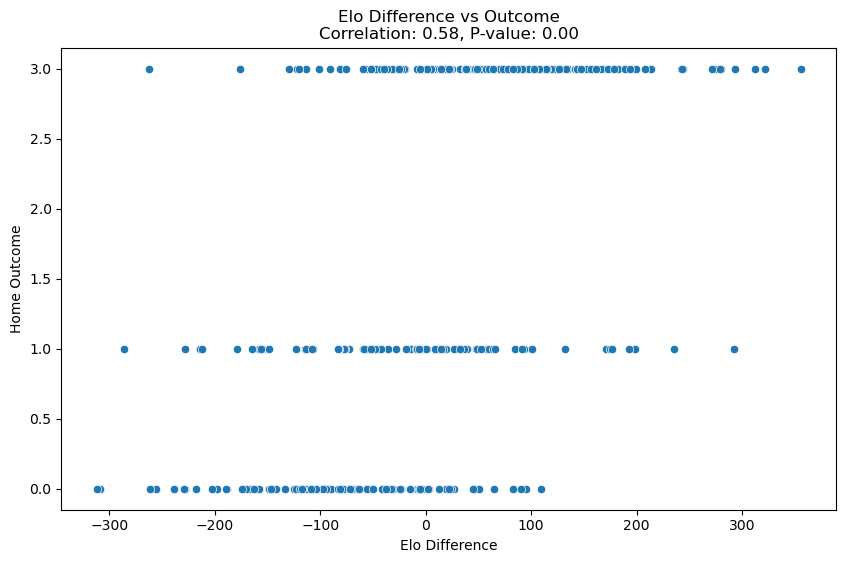

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Calculate Elo vs Outcome correlation
data_2023 = df[["Home Elo", "Away Elo", "Home Outcome"]].copy()
data_2023["Elo Difference"] = data_2023["Home Elo"] - data_2023["Away Elo"]

# Calculate correlation
correlation, p_value = pearsonr(data_2023["Elo Difference"], data_2023["Home Outcome"])

plt.figure(figsize=(10, 6))

# Visualization
sns.scatterplot(data=data_2023, x="Elo Difference", y="Home Outcome")
plt.title(f"Elo Difference vs Outcome\nCorrelation: {correlation:.2f}, P-value: {p_value:.2f}")
plt.show()